In [2]:
import numpy as np
import cv2
import pandas as pd
import os
import argparse
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, TimeDistributed, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [3]:
def load_video_frames_from_directory(n_videos, directory, img_height, img_width, start_frame=60, frame_gap=5):
    video_paths_positive = [os.path.join(directory, 'Accident', f) for f in os.listdir(os.path.join(directory, 'Accident')) if f.endswith('.mp4')]
    video_paths_negative = [os.path.join(directory, 'NonAccident', f) for f in os.listdir(os.path.join(directory, 'NonAccident')) if f.endswith('.mp4')]
    frames_list = []
    labels_list = []

    # Function to determine whether to include a frame based on the frame counter
    def include_frame(frame_counter):
        return (frame_counter >= start_frame) and ((frame_counter - start_frame) % frame_gap == 0)

    # Load videos with positive label
    positive_count = 0
    for video_path in video_paths_positive:
        if positive_count >= n_videos:
            break
        cap = cv2.VideoCapture(video_path)
        frame_counter = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            if include_frame(frame_counter):
                frame = cv2.resize(frame, (img_width, img_height))
                frames_list.append(frame)
                labels_list.append(1)  # Positive label
            frame_counter += 1
        cap.release()
        positive_count += 1

    # Load videos with negative label
    negative_count = 0
    for video_path in video_paths_negative:
        if negative_count >= n_videos:
            break
        cap = cv2.VideoCapture(video_path)
        frame_counter = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            if include_frame(frame_counter):
                frame = cv2.resize(frame, (img_width, img_height))
                frames_list.append(frame)
                labels_list.append(0)  # Negative label
            frame_counter += 1
        cap.release()
        negative_count += 1
    
    frames_array = np.array(frames_list)
    labels_array = np.array(labels_list)
    
    return frames_array, labels_array

In [24]:
# Define parameters
n_videos = 200  # Number of videos to load
directory = r'C:\Users\User\Desktop\Ajay\Main Data\train'
img_height = 224
img_width = 224
start_frame = 60
frame_gap = 5
batch_size = 32

# Load data
frames, labels = load_video_frames_from_directory(n_videos, directory, img_height, img_width, start_frame, frame_gap)

# Split data into train and test sets
train_frames, test_frames, train_labels, test_labels = train_test_split(frames, labels, test_size=0.2, random_state=42)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Apply data augmentation to frames
train_datagen = datagen.flow(train_frames, train_labels, batch_size=batch_size)
validation_datagen = datagen.flow(test_frames, test_labels, batch_size=batch_size)

In [25]:
# Load data
n_videos = 50  # Number of videos to load
directory = r'C:\Users\User\Desktop\Ajay\Main Data\test'
img_height = 224
img_width = 224
start_frame = 60
frame_gap = 5
batch_size = 32
frames, labels = load_video_frames_from_directory(n_videos, directory, img_height, img_width, start_frame, frame_gap)
test_datagen = datagen.flow(frames, labels, batch_size=batch_size)

MOBILENETV2

In [26]:
from tensorflow.keras.applications import MobileNetV2

# Define the input shape based on the dataset element_spec
input_shape = (224, 224, 3)
def create_mobilenetv2_model(input_shape):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    for layer in base_model.layers:
        layer.trainable = False  # Freeze pre-trained layers
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(64, activation='relu')(x)
    output = layers.Dense(1, activation='sigmoid')(x)  # Assuming binary classification
    model = models.Model(inputs=base_model.input, outputs=output)
    return model

mobilenetv2_model = create_mobilenetv2_model(input_shape)

# Compile the model
mobilenetv2_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                          loss=tf.keras.losses.BinaryCrossentropy(),
                          metrics=['accuracy'])

In [27]:
# Define a learning rate scheduler with adjusted parameters
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2, min_lr=0.00001)

# # Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [28]:
# Fit the model
mobilenetv2_history = mobilenetv2_model.fit(train_datagen,
                                             epochs=20,
                                             validation_data=validation_datagen,
                                             callbacks=[lr_scheduler, early_stopping])

Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 42s 485ms/step - accuracy: 0.4800 - loss: 0.7289 - val_accuracy: 0.5344 - val_loss: 0.6960 - learning_rate: 1.0000e-04
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 469ms/step - accuracy: 0.5420 - loss: 0.6859 - val_accuracy: 0.5672 - val_loss: 0.6793 - learning_rate: 1.0000e-04
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 39s 474ms/step - accuracy: 0.5943 - loss: 0.6676 - val_accuracy: 0.5797 - val_loss: 0.6734 - learning_rate: 1.0000e-04
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 469ms/step - accuracy: 0.5923 - loss: 0.6681 - val_accuracy: 0.6172 - val_loss: 0.6624 - learning_rate: 1.0000e-04
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 469ms/step - accuracy: 0.6057 - loss: 0.6554 - val_accuracy: 0.6297 - val_loss: 0.6417 - learning_rate: 1.0000e-04
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 468ms/step - accuracy: 0.6037 - loss: 0.6561 - val_accuracy: 0.6172 - val_loss: 0.6408 - learning_rate: 1.0000e-04
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 40s 490ms/step - acc

In [41]:
import pandas as pd

# Additional parameters
parameters = {
    'number_of_training_videos': 400,
    'number_of_test_videos': 100,
    'frames_starting_point': 60,
    'frame_gap': 5
}

# Extract specific data from training history
data_to_save = {
    'epoch': range(1, len(mobilenetv2_history.history['loss']) + 1),
    'train_loss': mobilenetv2_history.history['loss'],
    'val_loss': mobilenetv2_history.history['val_loss']
}

# Add parameters to data
data_to_save.update(parameters)

# Convert data to DataFrame
history_df = pd.DataFrame(data_to_save)

# Save DataFrame to CSV file
history_df.to_csv('mobilenetv2_training_history.csv', index=False)

In [42]:
import matplotlib.pyplot as plt

# Model Evaluation
def evaluate_model(model, test_ds):
    evaluation = model.evaluate(test_ds)
    print("Test Loss:", evaluation[0])
    print("Test Accuracy:", evaluation[1])

In [43]:
# Evaluate the model
evaluate_model(mobilenetv2_model, test_datagen)

25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 379ms/step - accuracy: 0.5288 - loss: 0.7181
Test Loss: 0.7056400775909424
Test Accuracy: 0.5262500047683716


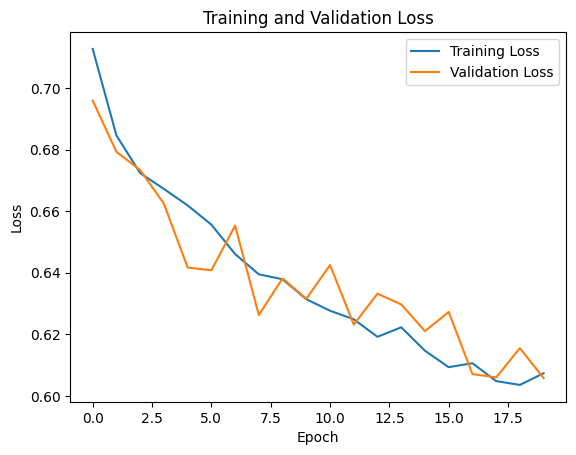

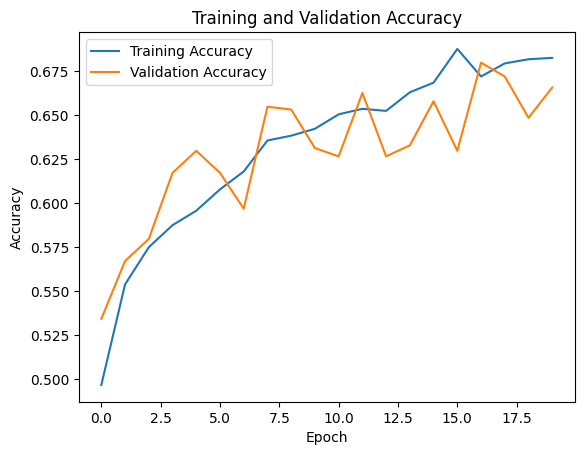

In [44]:
import matplotlib.pyplot as plt

# Plot training history
plt.plot(mobilenetv2_history.history['loss'], label='Training Loss')
plt.plot(mobilenetv2_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.plot(mobilenetv2_history.history['accuracy'], label='Training Accuracy')
plt.plot(mobilenetv2_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

INCEPTIONV3

In [45]:
from tensorflow.keras.applications import InceptionV3

# Define InceptionV3 model with modified top layers
input_shape = (224, 224, 3)
def create_inceptionv3_model(input_shape):
    # Load pre-trained InceptionV3 model
    base_model = InceptionV3(input_shape=input_shape, include_top=False, weights='imagenet')
    
    # Unfreeze some layers for fine-tuning
    for layer in base_model.layers[:-10]:
        layer.trainable = True
    
    # Add custom top layers
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(128, activation='relu')(x)  # Increase units for more representational power
    x = layers.Dropout(0.5)(x)  # Add dropout for regularization
    output = layers.Dense(1, activation='sigmoid')(x)  # Assuming binary classification
    
    # Create model
    model = models.Model(inputs=base_model.input, outputs=output)
    return model
# Create InceptionV3 model
inceptionv3_model = create_inceptionv3_model(input_shape)

# Compile the model
inceptionv3_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                          loss=tf.keras.losses.BinaryCrossentropy(),
                          metrics=['accuracy'])

In [77]:
inceptionv3_model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_94 (Conv2D)            │ (None, 111, 111, 32)      │             864 │ input_layer_6[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_94        │ (None, 111, 111, 32)      │              96 │ conv2d_94[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_94 (Activation)    │ (None, 111, 111, 32)      │               0 │ batch_normalization_94[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_95 (Conv2D)            │ (None, 109, 109, 32)      │           9,216 │ activation_94[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_95        │ (None, 109, 109, 32)      │              96 │ conv2d_95[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_95 (Activation)    │ (None, 109, 109, 32)      │               0 │ batch_normalization_95[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_96 (Conv2D)            │ (None, 109, 109, 64)      │          18,432 │ activation_95[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_96        │ (None, 109, 109, 64)      │             192 │ conv2d_96[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_96 (Activation)    │ (None, 109, 109, 64)      │               0 │ batch_normalization_96[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_4               │ (None, 54, 54, 64)        │               0 │ activation_96[0][0]        │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_97 (Conv2D)            │ (None, 54, 54, 80)        │           5,120 │ max_pooling2d_4[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_97        │ (None, 54, 54, 80)        │             240 │ conv2d_97[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_97 (Activation)    │ (None, 54, 54, 80)        │               0 │ batch_normalization_97[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_98 (Conv2D)            │ (None, 52, 52, 192)       │         138,24

 Total params: 66,126,693 (252.25 MB)

 Trainable params: 22,030,753 (84.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

 Optimizer params: 44,061,508 (168.08 MB)

In [46]:
# Define a learning rate scheduler with adjusted parameters
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2, min_lr=0.00001)

# # Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [47]:
# Fit the model
inceptionv3_history = inceptionv3_model.fit(train_datagen,
                                            epochs=20,
                                            validation_data=validation_datagen,
                                            callbacks=[lr_scheduler, early_stopping])

Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 0.5942 - loss: 0.6872 - val_accuracy: 0.7297 - val_loss: 0.5619 - learning_rate: 1.0000e-04
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.8001 - loss: 0.4130 - val_accuracy: 0.8516 - val_loss: 0.4101 - learning_rate: 1.0000e-04
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.9096 - loss: 0.2272 - val_accuracy: 0.8906 - val_loss: 0.3003 - learning_rate: 1.0000e-04
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.9522 - loss: 0.1444 - val_accuracy: 0.9500 - val_loss: 0.1419 - learning_rate: 1.0000e-04
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.9577 - loss: 0.1082 - val_accuracy: 0.9563 - val_loss: 0.1154 - learning_rate: 1.0000e-04
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.9720 - loss: 0.0894 - val_accuracy: 0.9297 - val_loss: 0.1865 - learning_rate: 1.0000e-04
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.9719 

In [48]:
import pandas as pd

# Additional parameters
parameters = {
    'number_of_training_videos': 400,
    'number_of_test_videos': 100,
    'frames_starting_point': 60,
    'frame_gap': 5
}

# Extract specific data from training history
data_to_save = {
    'epoch': range(1, len(inceptionv3_history.history['loss']) + 1),
    'train_loss': inceptionv3_history.history['loss'],
    'val_loss': inceptionv3_history.history['val_loss']
}

# Add parameters to data
data_to_save.update(parameters)

# Convert data to DataFrame
history_df = pd.DataFrame(data_to_save)

# Save DataFrame to CSV file
history_df.to_csv('inceptionv3_history.csv', index=False)

In [49]:
# Evaluate the model
evaluate_model(inceptionv3_model, test_datagen)

25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 459ms/step - accuracy: 0.5718 - loss: 2.4452
Test Loss: 2.5874199867248535
Test Accuracy: 0.5325000286102295


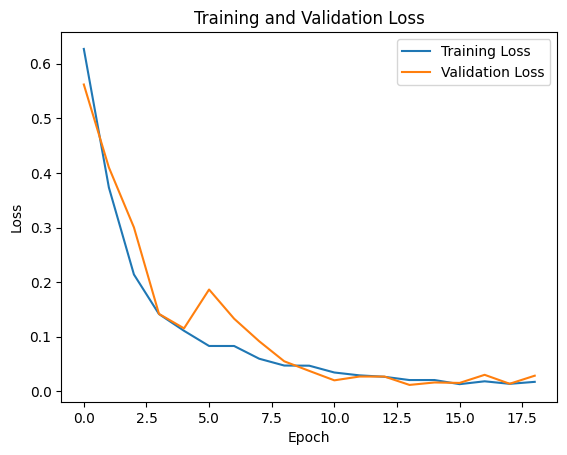

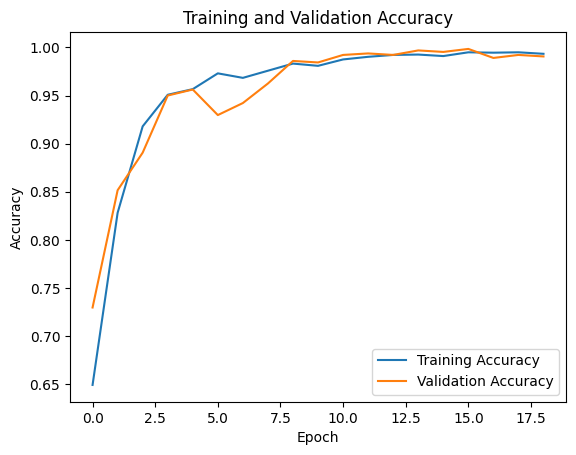

In [50]:
import matplotlib.pyplot as plt

# Plot training history
plt.plot(inceptionv3_history.history['loss'], label='Training Loss')
plt.plot(inceptionv3_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.plot(inceptionv3_history.history['accuracy'], label='Training Accuracy')
plt.plot(inceptionv3_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

VGG16

In [51]:
from tensorflow.keras.applications import VGG16

def create_vgg16_model(input_shape):
    base_model = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')
    for layer in base_model.layers:
        layer.trainable = False  # Freeze pre-trained layers
    x = layers.Flatten()(base_model.output)
    x = layers.Dense(64, activation='relu')(x)
    output = layers.Dense(1, activation='sigmoid')(x)  # Assuming binary classification
    model = models.Model(inputs=base_model.input, outputs=output)
    return model

vgg16_model = create_vgg16_model(input_shape)

# Compile the model
vgg16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                    loss=tf.keras.losses.BinaryCrossentropy(),
                    metrics=['accuracy'])

In [52]:
# Define a learning rate scheduler with adjusted parameters
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2, min_lr=0.00001)

# # Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [53]:
# Fit the model
vgg16_history = vgg16_model.fit(train_datagen,
                                epochs=20,
                                validation_data=validation_datagen,
                                callbacks=[lr_scheduler, early_stopping])

Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.5367 - loss: 2.7833 - val_accuracy: 0.6484 - val_loss: 0.6795 - learning_rate: 1.0000e-04
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.6290 - loss: 0.6744 - val_accuracy: 0.6953 - val_loss: 0.6037 - learning_rate: 1.0000e-04
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.7213 - loss: 0.5432 - val_accuracy: 0.7344 - val_loss: 0.5564 - learning_rate: 1.0000e-04
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.7587 - loss: 0.4995 - val_accuracy: 0.7344 - val_loss: 0.5127 - learning_rate: 1.0000e-04
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.7853 - loss: 0.4619 - val_accuracy: 0.8094 - val_loss: 0.4277 - learning_rate: 1.0000e-04
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.8290 - loss: 0.3908 - val_accuracy: 0.8094 - val_loss: 0.4154 - learning_rate: 1.0000e-04
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.8347 

In [54]:
# Evaluate the model
evaluate_model(vgg16_model, test_datagen)

25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5414 - loss: 1.3114
Test Loss: 1.2783294916152954
Test Accuracy: 0.5575000047683716


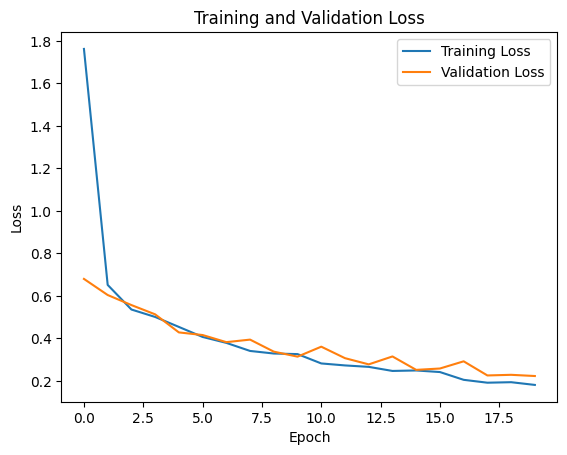

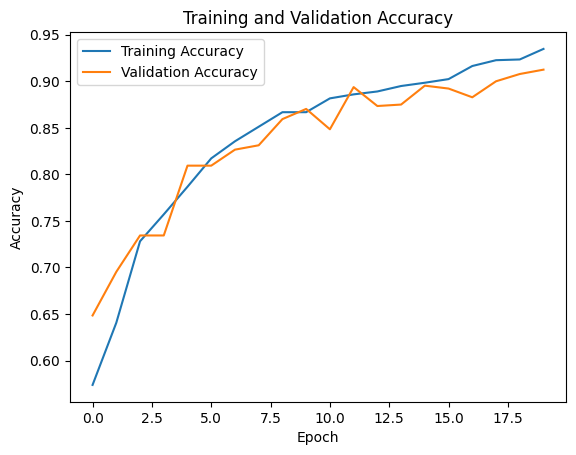

In [55]:
import matplotlib.pyplot as plt

# Plot training history
plt.plot(vgg16_history.history['loss'], label='Training Loss')
plt.plot(vgg16_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.plot(vgg16_history.history['accuracy'], label='Training Accuracy')
plt.plot(vgg16_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [56]:
import pandas as pd

# Additional parameters
parameters = {
    'number_of_training_videos': 400,
    'number_of_test_videos': 100,
    'frames_starting_point': 60,
    'frame_gap': 5
}

# Extract specific data from training history
data_to_save = {
    'epoch': range(1, len(vgg16_history.history['loss']) + 1),
    'train_loss': vgg16_history.history['loss'],
    'val_loss': vgg16_history.history['val_loss']
}

# Add parameters to data
data_to_save.update(parameters)

# Convert data to DataFrame
history_df = pd.DataFrame(data_to_save)

# Save DataFrame to CSV file
history_df.to_csv('vgg16_history.csv', index=False)

In [57]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

def create_vgg16_lstm_model(input_shape, lstm_units=32, num_classes=1):
    # Initialize VGG16 model with pre-trained weights
    base_model = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')
    
    # Freeze pre-trained layers
    for layer in base_model.layers:
        layer.trainable = False
        
    # Flatten output from VGG16
    x = layers.Flatten()(base_model.output)
    
    # Add dense layers
    x = layers.Dense(64, activation='relu')(x)
    
    # Add LSTM layer
    x = layers.Reshape((1, -1))(x)  # Reshape to match LSTM input shape
    x = layers.LSTM(lstm_units)(x)
    
    # Add output layer for binary classification
    output = layers.Dense(num_classes, activation='sigmoid')(x)
    
    # Create the model
    model = models.Model(inputs=base_model.input, outputs=output)
    
    return model

# Example usage:
input_shape = (224, 224, 3)  # Example input shape for VGG16
vgg16_lstm_model = create_vgg16_lstm_model(input_shape)
vgg16_lstm_model.summary()


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 64)                  │       1,605,696 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 16,332,833 (62.30 MB)

 Trainable params: 1,618,145 (6.17 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [58]:
# Compile the model
vgg16_lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                          loss=tf.keras.losses.BinaryCrossentropy(),
                          metrics=['accuracy'])

In [59]:
# Define a learning rate scheduler with adjusted parameters
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2, min_lr=0.00001)

# # Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [60]:
# Fit the model
vgg16_lstm_model_history = vgg16_lstm_model.fit(train_datagen,
                                epochs=20,
                                validation_data=validation_datagen,
                                callbacks=[lr_scheduler, early_stopping])

Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.5122 - loss: 0.7029 - val_accuracy: 0.5594 - val_loss: 0.6793 - learning_rate: 1.0000e-04
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.5990 - loss: 0.6653 - val_accuracy: 0.6484 - val_loss: 0.6378 - learning_rate: 1.0000e-04
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.6730 - loss: 0.6255 - val_accuracy: 0.7312 - val_loss: 0.5930 - learning_rate: 1.0000e-04
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.7209 - loss: 0.5852 - val_accuracy: 0.6953 - val_loss: 0.5973 - learning_rate: 1.0000e-04
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.7431 - loss: 0.5513 - val_accuracy: 0.7563 - val_loss: 0.5469 - learning_rate: 1.0000e-04
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.7613 - loss: 0.5362 - val_accuracy: 0.7750 - val_loss: 0.5242 - learning_rate: 1.0000e-04
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.7927 

In [61]:
# Evaluate the model
evaluate_model(vgg16_model, test_datagen)

25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5499 - loss: 1.2694
Test Loss: 1.262952446937561
Test Accuracy: 0.5575000047683716


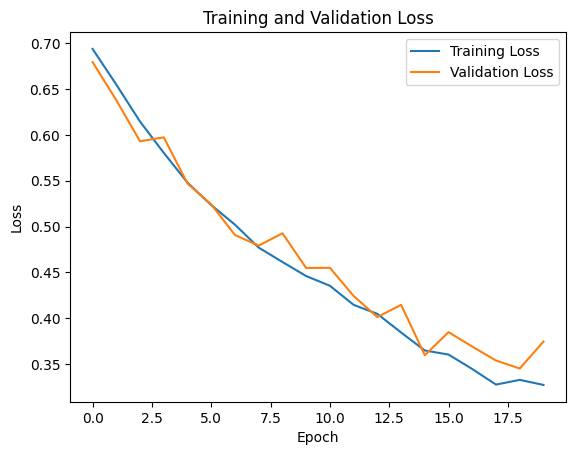

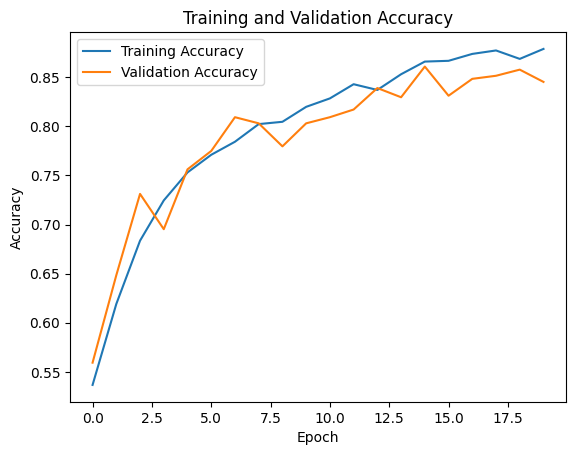

In [62]:
import matplotlib.pyplot as plt

# Plot training history
plt.plot(vgg16_lstm_model_history.history['loss'], label='Training Loss')
plt.plot(vgg16_lstm_model_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.plot(vgg16_lstm_model_history.history['accuracy'], label='Training Accuracy')
plt.plot(vgg16_lstm_model_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [63]:
import pandas as pd

# Additional parameters
parameters = {
    'number_of_training_videos': 400,
    'number_of_test_videos': 100,
    'frames_starting_point': 60,
    'frame_gap': 5
}

# Extract specific data from training history
data_to_save = {
    'epoch': range(1, len(vgg16_lstm_model_history.history['loss']) + 1),
    'train_loss': vgg16_lstm_model_history.history['loss'],
    'val_loss': vgg16_lstm_model_history.history['val_loss']
}

# Add parameters to data
data_to_save.update(parameters)

# Convert data to DataFrame
history_df = pd.DataFrame(data_to_save)

# Save DataFrame to CSV file
history_df.to_csv('vgg16_lstm_model_history.csv', index=False)

In [78]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3

# Define InceptionV3 model with modified top layers
input_shape = (224, 224, 3)

def create_inceptionv3_lstm_model(input_shape, lstm_units=32,num_classes=1):
    # Load pre-trained InceptionV3 model
    base_model = InceptionV3(input_shape=input_shape, include_top=False, weights='imagenet')
    
    # Unfreeze some layers for fine-tuning
    for layer in base_model.layers[:-10]:
        layer.trainable = True
    
    #Flatten output from InceptionV3 model
    x = layers.Flatten()(base_model.output)
    
    # Add dense layers
    x = layers.Dense(64, activation='relu')(x)
    
    # Add LSTM layer
    x = layers.Reshape((1, -1))(x)  # Reshape to match LSTM input shape
    x = layers.LSTM(lstm_units)(x)
    
    # Add output layer for binary classification
    output = layers.Dense(num_classes, activation='sigmoid')(x)
    
    # Create the model
    model = models.Model(inputs=base_model.input, outputs=output)
    
    return model

# Create InceptionV3 + LSTM model
inceptionv3_lstm_model = create_inceptionv3_lstm_model(input_shape)

In [79]:
# Compile the model
inceptionv3_lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                                loss=tf.keras.losses.BinaryCrossentropy(),
                                metrics=['accuracy'])

In [80]:
# Define a learning rate scheduler with adjusted parameters
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2, min_lr=0.00001)

# # Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [81]:
# Fit the model
inceptionv3_lstm_model_history = inceptionv3_lstm_model.fit(train_datagen,
                                epochs=20,
                                validation_data=validation_datagen,
                                callbacks=[lr_scheduler, early_stopping])

Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.5671 - loss: 0.6815 - val_accuracy: 0.6250 - val_loss: 0.6903 - learning_rate: 1.0000e-04
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.8039 - loss: 0.4631 - val_accuracy: 0.7203 - val_loss: 0.6231 - learning_rate: 1.0000e-04
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.8904 - loss: 0.2971 - val_accuracy: 0.8625 - val_loss: 0.3690 - learning_rate: 1.0000e-04
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.9194 - loss: 0.2042 - val_accuracy: 0.9219 - val_loss: 0.2155 - learning_rate: 1.0000e-04
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.9596 - loss: 0.1285 - val_accuracy: 0.9062 - val_loss: 0.2494 - learning_rate: 1.0000e-04
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.9652 - loss: 0.1170 - val_accuracy: 0.9484 - val_loss: 0.1626 - learning_rate: 1.0000e-04
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.9719 

In [82]:
# Evaluate the model
evaluate_model(inceptionv3_lstm_model, test_datagen)

25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 442ms/step - accuracy: 0.5243 - loss: 1.6631
Test Loss: 1.654647707939148
Test Accuracy: 0.53125


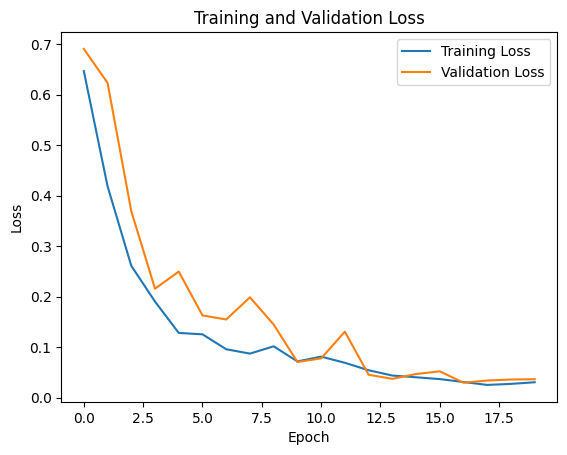

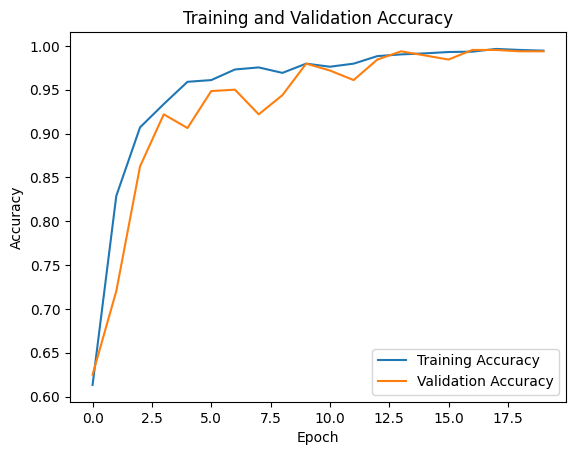

In [83]:
import matplotlib.pyplot as plt

# Plot training history
plt.plot(inceptionv3_lstm_model_history.history['loss'], label='Training Loss')
plt.plot(inceptionv3_lstm_model_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.plot(inceptionv3_lstm_model_history.history['accuracy'], label='Training Accuracy')
plt.plot(inceptionv3_lstm_model_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [85]:
import pandas as pd

# Additional parameters
parameters = {
    'number_of_training_videos': 400,
    'number_of_test_videos': 100,
    'frames_starting_point': 60,
    'frame_gap': 5
}

# Extract specific data from training history
data_to_save = {
    'epoch': range(1, len(inceptionv3_lstm_model_history.history['loss']) + 1),
    'train_loss': inceptionv3_lstm_model_history.history['loss'],
    'val_loss': inceptionv3_lstm_model_history.history['val_loss']
}

# Add parameters to data
data_to_save.update(parameters)

# Convert data to DataFrame
history_df = pd.DataFrame(data_to_save)

# Save DataFrame to CSV file
history_df.to_csv('inceptionv3_lstm_model_history.csv', index=False)

In [88]:
from tensorflow.keras.applications import MobileNetV2

# Define the input shape based on the dataset element_spec
input_shape = (224, 224, 3)
def create_mobilenetv2_lstm_model(input_shape):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    for layer in base_model.layers:
        layer.trainable = False  # Freeze pre-trained layers
    
    #Flatten output from InceptionV3 model
    x = layers.Flatten()(base_model.output)
    
    # Add dense layers
    x = layers.Dense(64, activation='relu')(x)
    
    # Add LSTM layer
    x = layers.Reshape((1, -1))(x)  # Reshape to match LSTM input shape
    x = layers.LSTM(32)(x)
    
    # Add output layer for binary classification
    output = layers.Dense(1, activation='sigmoid')(x)
    
    # Create the model
    model = models.Model(inputs=base_model.input, outputs=output)
    
    return model

# Create InceptionV3 + LSTM model
mobilenetv2_lstm_model = create_mobilenetv2_lstm_model(input_shape)

In [91]:
# Compile the model
mobilenetv2_lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                                loss=tf.keras.losses.BinaryCrossentropy(),
                                metrics=['accuracy'])

In [92]:
# Define a learning rate scheduler with adjusted parameters
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2, min_lr=0.00001)

# # Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [93]:
# Fit the model
mobilenetv2_lstm_model_history = mobilenetv2_lstm_model.fit(train_datagen,
                                epochs=20,
                                validation_data=validation_datagen,
                                callbacks=[lr_scheduler, early_stopping])

Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 45s 516ms/step - accuracy: 0.5204 - loss: 0.6940 - val_accuracy: 0.5625 - val_loss: 0.6691 - learning_rate: 1.0000e-04
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 40s 494ms/step - accuracy: 0.6021 - loss: 0.6662 - val_accuracy: 0.6344 - val_loss: 0.6486 - learning_rate: 1.0000e-04
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 40s 493ms/step - accuracy: 0.6275 - loss: 0.6516 - val_accuracy: 0.5250 - val_loss: 0.7124 - learning_rate: 1.0000e-04
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 41s 496ms/step - accuracy: 0.6276 - loss: 0.6377 - val_accuracy: 0.6812 - val_loss: 0.6251 - learning_rate: 1.0000e-04
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 41s 496ms/step - accuracy: 0.6708 - loss: 0.6082 - val_accuracy: 0.6641 - val_loss: 0.6159 - learning_rate: 1.0000e-04
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 40s 493ms/step - accuracy: 0.7006 - loss: 0.5881 - val_accuracy: 0.6984 - val_loss: 0.5901 - learning_rate: 1.0000e-04
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 41s 496ms/step - acc

In [94]:
# Evaluate the model
evaluate_model(mobilenetv2_lstm_model, test_datagen)

25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 382ms/step - accuracy: 0.5144 - loss: 0.8802
Test Loss: 0.8596900105476379
Test Accuracy: 0.5337499976158142


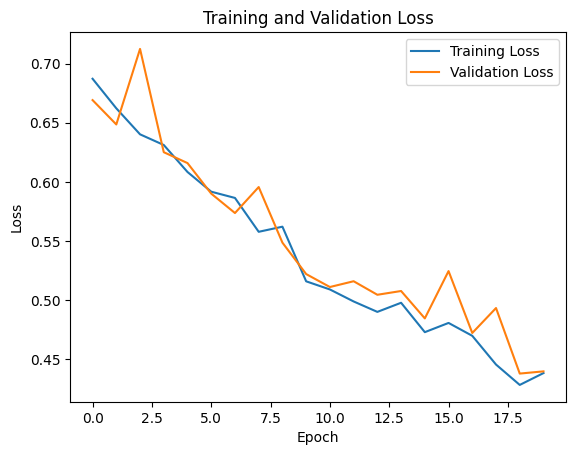

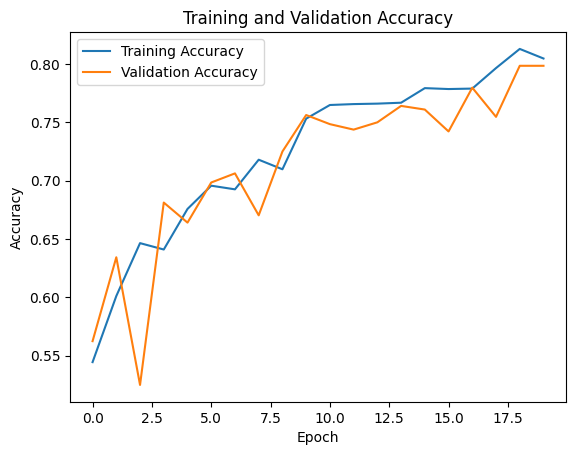

In [95]:
import matplotlib.pyplot as plt

# Plot training history
plt.plot(mobilenetv2_lstm_model_history.history['loss'], label='Training Loss')
plt.plot(mobilenetv2_lstm_model_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.plot(mobilenetv2_lstm_model_history.history['accuracy'], label='Training Accuracy')
plt.plot(mobilenetv2_lstm_model_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [96]:
import pandas as pd

# Additional parameters
parameters = {
    'number_of_training_videos': 400,
    'number_of_test_videos': 100,
    'frames_starting_point': 60,
    'frame_gap': 5
}

# Extract specific data from training history
data_to_save = {
    'epoch': range(1, len(mobilenetv2_lstm_model_history.history['loss']) + 1),
    'train_loss': mobilenetv2_lstm_model_history.history['loss'],
    'val_loss': mobilenetv2_lstm_model_history.history['val_loss']
}

# Add parameters to data
data_to_save.update(parameters)

# Convert data to DataFrame
history_df = pd.DataFrame(data_to_save)

# Save DataFrame to CSV file
history_df.to_csv('mobilenetv2_lstm_model_history.csv', index=False)